# LSTM model
The best architecture taken from **Load Prediction 4**
### features
tmp, wind, swrad, lwrad for each of the select_stations
day of the week
hour of the day
month of the year

### prediction frame
with n = 6 and m = 4
features:
t-n to t+m-1 of climate and time
labels:
t to t+m-1 of load ERCOT

In [1]:
import sys
 
# setting path
sys.path.append('../../../../data')
from data import *

ModuleNotFoundError: No module named 'data'

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,  Flatten

import matplotlib.pyplot as plt

from statistics import mean, stdev
import pandas as pd
import numpy as np
import datetime

In [ ]:
start = datetime.datetime.now()

In [ ]:
past_hours = 6
n_steps = past_hours
next_hours = 4
next_steps = next_hours

In [ ]:
transformations = [e for n in select_stations for e in ('swrad'+str(n), 'lwrad'+str(n), 'wind'+str(n))]
transformations = [(str(i), MinMaxScaler(copy=True), make_column_selector(pattern = e)) for i,e in enumerate(transformations)]
transformations += [("y",StandardScaler(copy=True), make_column_selector(pattern = 'ERCOT'))]
ct = ColumnTransformer(transformations)

normed_data = pd.DataFrame(ct.fit_transform(load_data))
normed_data

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.229848,0.175246,0.0,0.236395,0.288098,0.0,0.196951,0.158924,0.0,...,0.0,0.249152,0.301783,0.0,0.229748,0.367275,0.0,0.313191,0.435409,-0.861036
1,0.0,0.229824,0.200738,0.0,0.236392,0.257994,0.0,0.196983,0.167568,0.0,...,0.0,0.249141,0.283376,0.0,0.229736,0.333039,0.0,0.313168,0.407110,-0.727637
2,0.0,0.194472,0.226748,0.0,0.195790,0.229942,0.0,0.158500,0.176048,0.0,...,0.0,0.205188,0.265043,0.0,0.198843,0.300108,0.0,0.272950,0.380431,-0.782265
3,0.0,0.194472,0.217296,0.0,0.195790,0.191008,0.0,0.158507,0.185629,0.0,...,0.0,0.205188,0.248931,0.0,0.198843,0.296627,0.0,0.272944,0.359858,-0.941622
4,0.0,0.194454,0.213117,0.0,0.195790,0.155684,0.0,0.158539,0.195340,0.0,...,0.0,0.205188,0.233765,0.0,0.198843,0.293006,0.0,0.272944,0.341684,-1.188049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94909,0.0,0.543971,0.151403,0.0,0.528028,0.254790,0.0,0.568888,0.282454,0.0,...,0.0,0.630416,0.210952,0.0,0.529407,0.341912,0.0,0.565430,0.422939,0.436792
94910,0.0,0.520742,0.164654,0.0,0.607941,0.214727,0.0,0.601077,0.251925,0.0,...,0.0,0.573577,0.199279,0.0,0.516931,0.351189,0.0,0.516769,0.470763,0.269458
94911,0.0,0.520742,0.242358,0.0,0.607941,0.168782,0.0,0.601074,0.197461,0.0,...,0.0,0.573574,0.172002,0.0,0.516931,0.330749,0.0,0.516749,0.476552,0.129600
94912,0.0,0.520742,0.327699,0.0,0.607941,0.123072,0.0,0.601074,0.144117,0.0,...,0.0,0.573574,0.144918,0.0,0.516915,0.310780,0.0,0.516749,0.483156,-0.005014


In [ ]:
dataset = normed_data.values
steps = n_steps+next_steps
time_series =  np.array([dataset[i:i + steps].copy() for i in range(len(dataset) - steps) if load_data.index[i+steps] - load_data.index[i] == datetime.timedelta(hours=steps)])

time_series.shape

(94378, 10, 25)

In [ ]:
X = time_series[:, :n_steps, :]
Y = time_series[:, n_steps:, -1]

print(X.shape, Y.shape)

(94378, 6, 25) (94378, 4)


In [ ]:
#sizes for test, train, and validation datasets
a = len(time_series)
b = int(0.9*a)
c = int(a-b)//2

In [ ]:
X_train,    Y_train =   X[:b],      Y[:b]
X_val,      Y_val   =   X[b:b+c],   Y[b:b+c]
X_test,     Y_test  =   X[b+c:],    Y[b+c:]

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(84940, 6, 25) (4719, 6, 25) (4719, 6, 25)
(84940, 4) (4719, 4) (4719, 4)


In [ ]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Flatten(),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(next_steps)
])

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                decay_steps=1000000,
                                                decay_rate=0.98,
                                                  staircase=False)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=1e-6)

model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 256)            288768    
                                                                 
 lstm_1 (LSTM)               (None, 6, 256)            525312    
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
EPOCHS = 30

history = model.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1)

Epoch 1/30
2655/2655 [==============================] - 195s 65ms/step - loss: 0.0956 - mae: 0.2315 - mse: 0.0956 - val_loss: 0.0685 - val_mae: 0.2005 - val_mse: 0.0685
Epoch 2/30
2655/2655 [==============================] - 177s 67ms/step - loss: 0.0422 - mae: 0.1547 - mse: 0.0422 - val_loss: 0.0396 - val_mae: 0.1430 - val_mse: 0.0396
Epoch 3/30
2655/2655 [==============================] - 213s 80ms/step - loss: 0.0327 - mae: 0.1358 - mse: 0.0327 - val_loss: 0.0343 - val_mae: 0.1365 - val_mse: 0.0343
Epoch 4/30
2655/2655 [==============================] - 237s 89ms/step - loss: 0.0280 - mae: 0.1254 - mse: 0.0280 - val_loss: 0.0300 - val_mae: 0.1254 - val_mse: 0.0300
Epoch 5/30
2655/2655 [==============================] - 241s 91ms/step - loss: 0.0242 - mae: 0.1167 - mse: 0.0242 - val_loss: 0.0261 - val_mae: 0.1152 - val_mse: 0.0261
Epoch 6/30
2655/2655 [==============================] - 240s 90ms/step - loss: 0.0225 - mae: 0.1118 - mse: 0.0225 - val_loss: 0.0296 - val_mae: 0.1352 - va

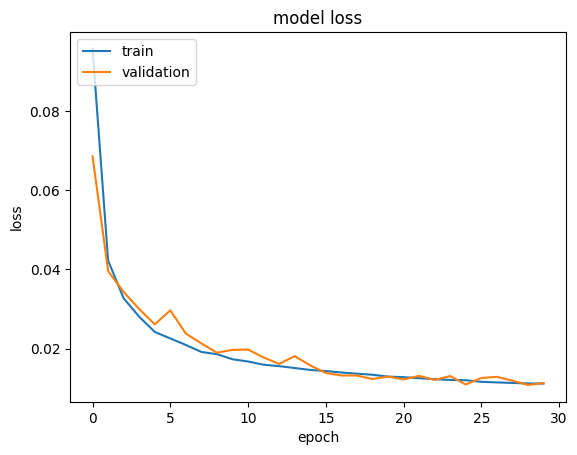

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_predictions = model.predict(X_test)
op_list= [e for y in test_predictions for e in y]   #predicted list
ip_list = [e for y in Y_test for e in y]    #actual list
print(len(op_list), len(ip_list))

148/148 [==============================] - 3s 17ms/step
18876 18876


In [ ]:
test_labels = pd.DataFrame({'actual':ip_list})
predictions = pd.DataFrame({'predict':op_list})
test_labels['actual'] = ct.named_transformers_['y'].inverse_transform(test_labels)
predictions['predict'] = ct.named_transformers_['y'].inverse_transform(predictions)

error = predictions['predict'] - test_labels['actual']
rerror = 100*(predictions['predict'] - test_labels['actual'])/test_labels['actual']

print('Mean of error in test data:', mean(error))
print('Mean of absolute error in test data:', mean(abs(error)))
print('Root of mean of squared error in test data:', mean(error**2)**0.5)
print('Standard deviation of error in test data:', stdev(error))
print("=============================================================")
print('MPE (%):', mean(rerror))
print('MAPE (%):', mean(abs(rerror)))
print('RMSPE (%):', mean(rerror**2)**0.5)
print('Deviation of error (%):', stdev(rerror))
print("=============================================================")
print('Mean of test data:', mean(test_labels['actual']))
print('Standard deviation of test data:', stdev(test_labels['actual']))
print("Coefficient of determination:",r2_score(test_labels['actual'], predictions['predict']))

Mean of error in test data: -348.09809953777284
Mean of absolute error in test data: 910.0448703545508
Root of mean of squared error in test data: 1297.946439370909
Standard deviation of error in test data: 1250.4301286448153
MPE (%): -0.4551668611141924
MAPE (%): 1.8395489577300501
RMSPE (%): 2.4720085410890693
Deviation of error (%): 2.4298070153585387
Mean of test data: 47586.94378734902
Standard deviation of test data: 10122.94285891266
Coefficient of determination: 0.9835591987085626


In [ ]:
#absolute errors
for threshold in [5,10,50,100,500,1000,1500,2000,3000,4000,5000]:
    accuracy = sum(abs(e) < threshold for e in error)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 0.4344140707777071 % with threshold of 5
accuracy: 0.8635304089849545 % with threshold of 10
accuracy: 4.179910998092817 % with threshold of 50
accuracy: 8.418097054460691 % with threshold of 100
accuracy: 41.121000211909305 % with threshold of 500
accuracy: 67.78448823903369 % with threshold of 1000
accuracy: 82.5863530408985 % with threshold of 1500
accuracy: 89.99788090697182 % with threshold of 2000
accuracy: 96.0955710955711 % with threshold of 3000
accuracy: 98.21996185632548 % with threshold of 4000
accuracy: 99.31129476584022 % with threshold of 5000


In [ ]:
#relative errors
for threshold in [0.5,1,1.5,2,3,4,5]:
    accuracy = sum(abs(e) < threshold for e in rerror)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 19.050646323373595 % with threshold of 0.5
accuracy: 37.243059970332695 % with threshold of 1
accuracy: 52.7972027972028 % with threshold of 1.5
accuracy: 65.4216995126086 % with threshold of 2
accuracy: 81.64335664335664 % with threshold of 3
accuracy: 90.40050858232676 % with threshold of 4
accuracy: 94.80822208094935 % with threshold of 5


In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 48})

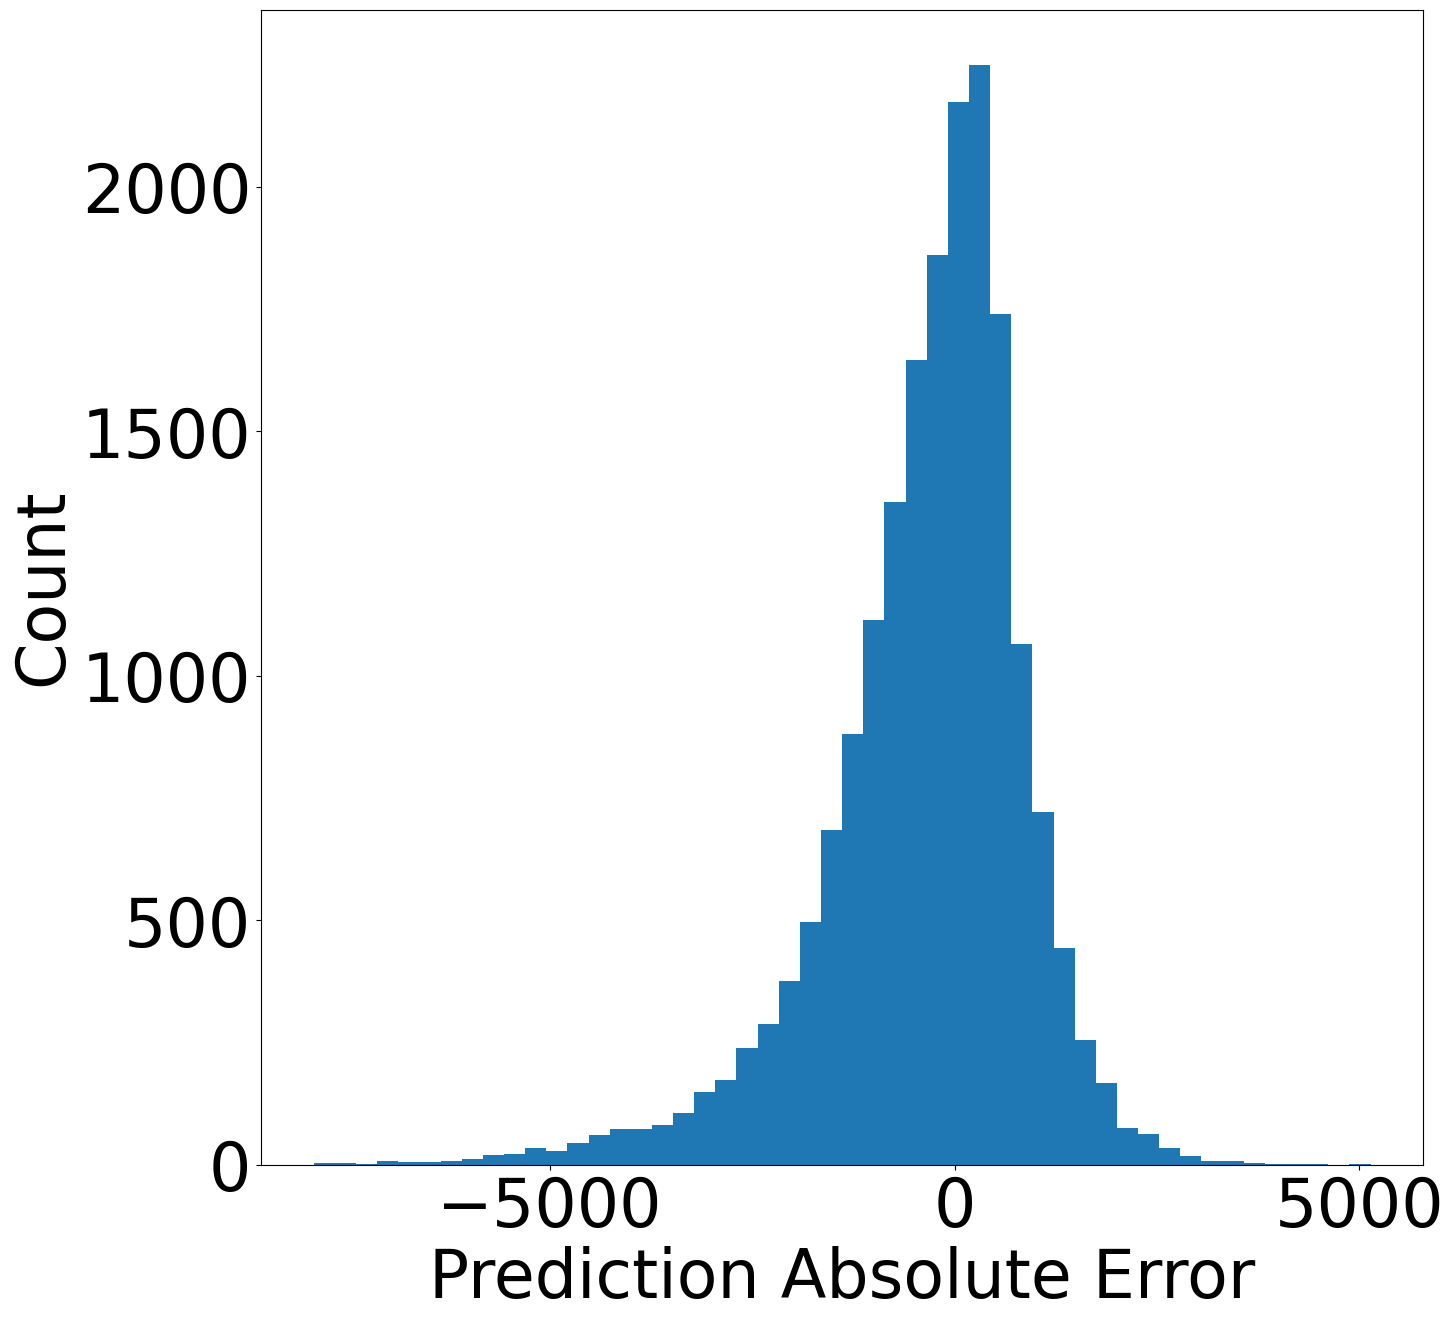

In [ ]:
plt.figure(figsize=(15,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Absolute Error")
_ = plt.ylabel("Count")

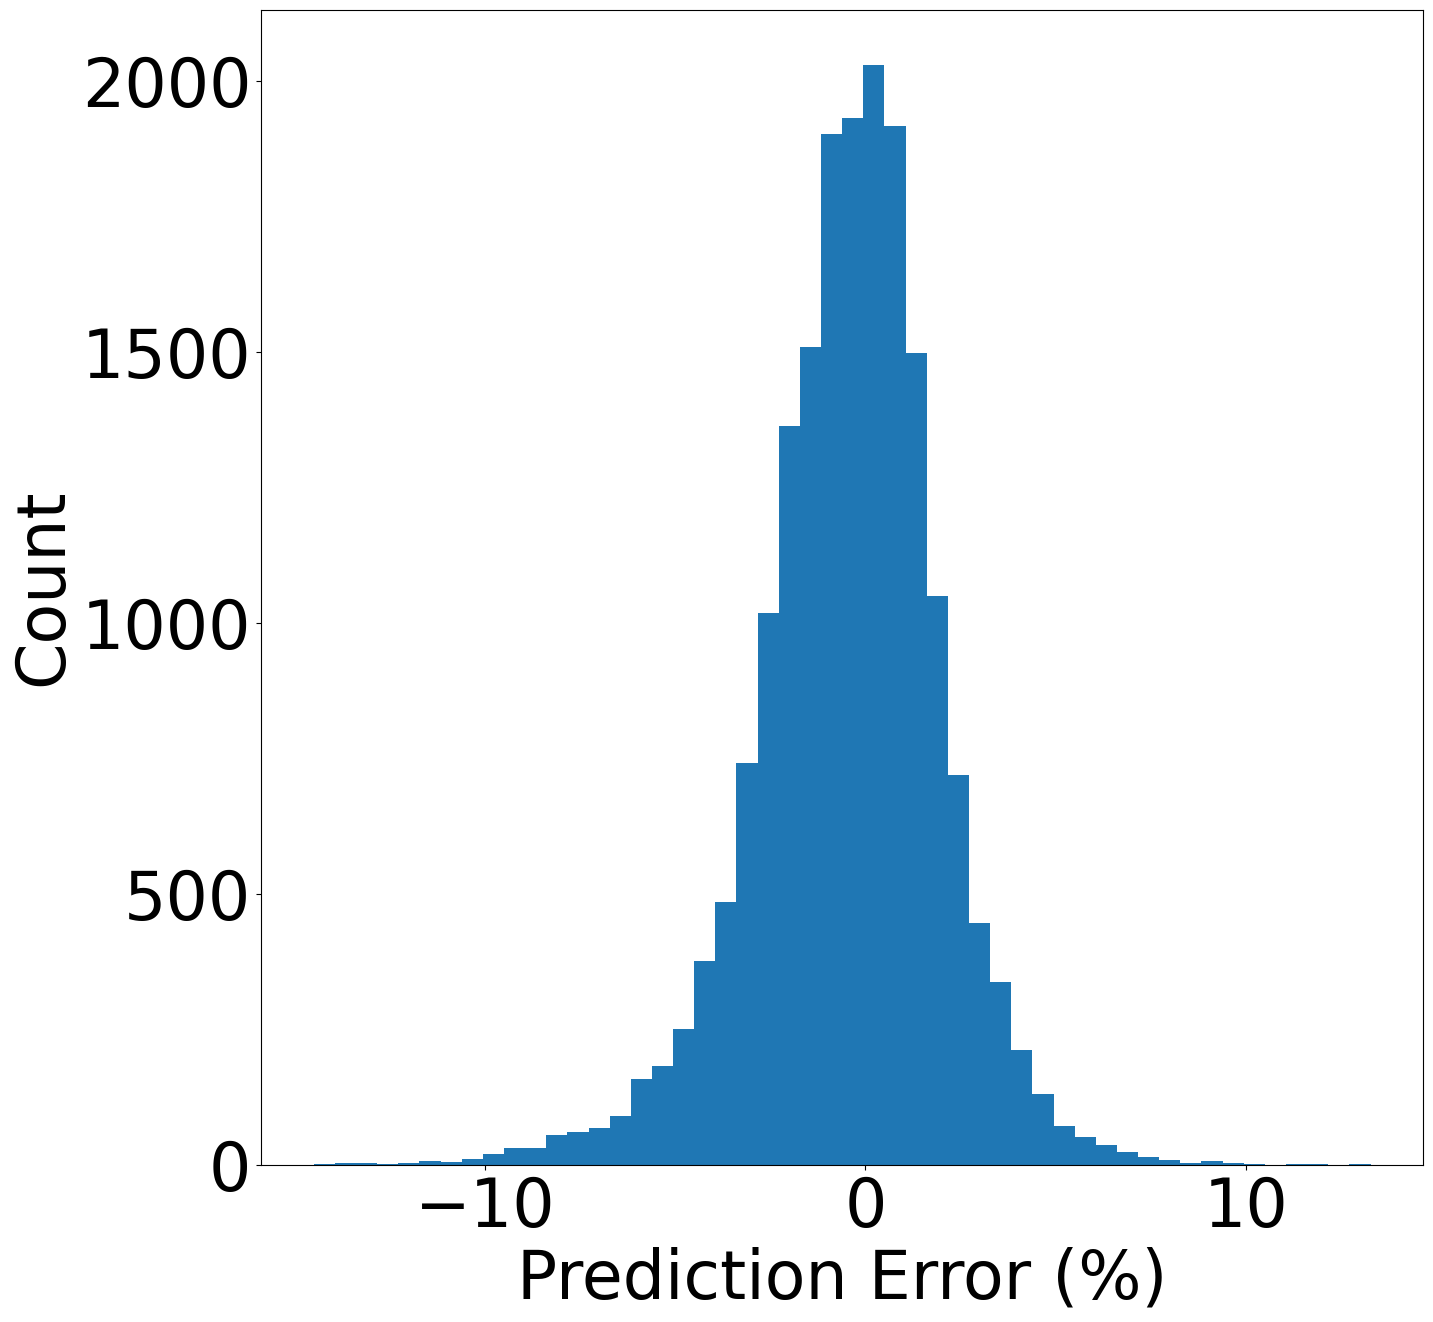

In [ ]:
plt.figure(figsize=(15,15))
plt.hist(rerror, bins = 50)
plt.xlabel("Prediction Error (%)")
_ = plt.ylabel("Count")

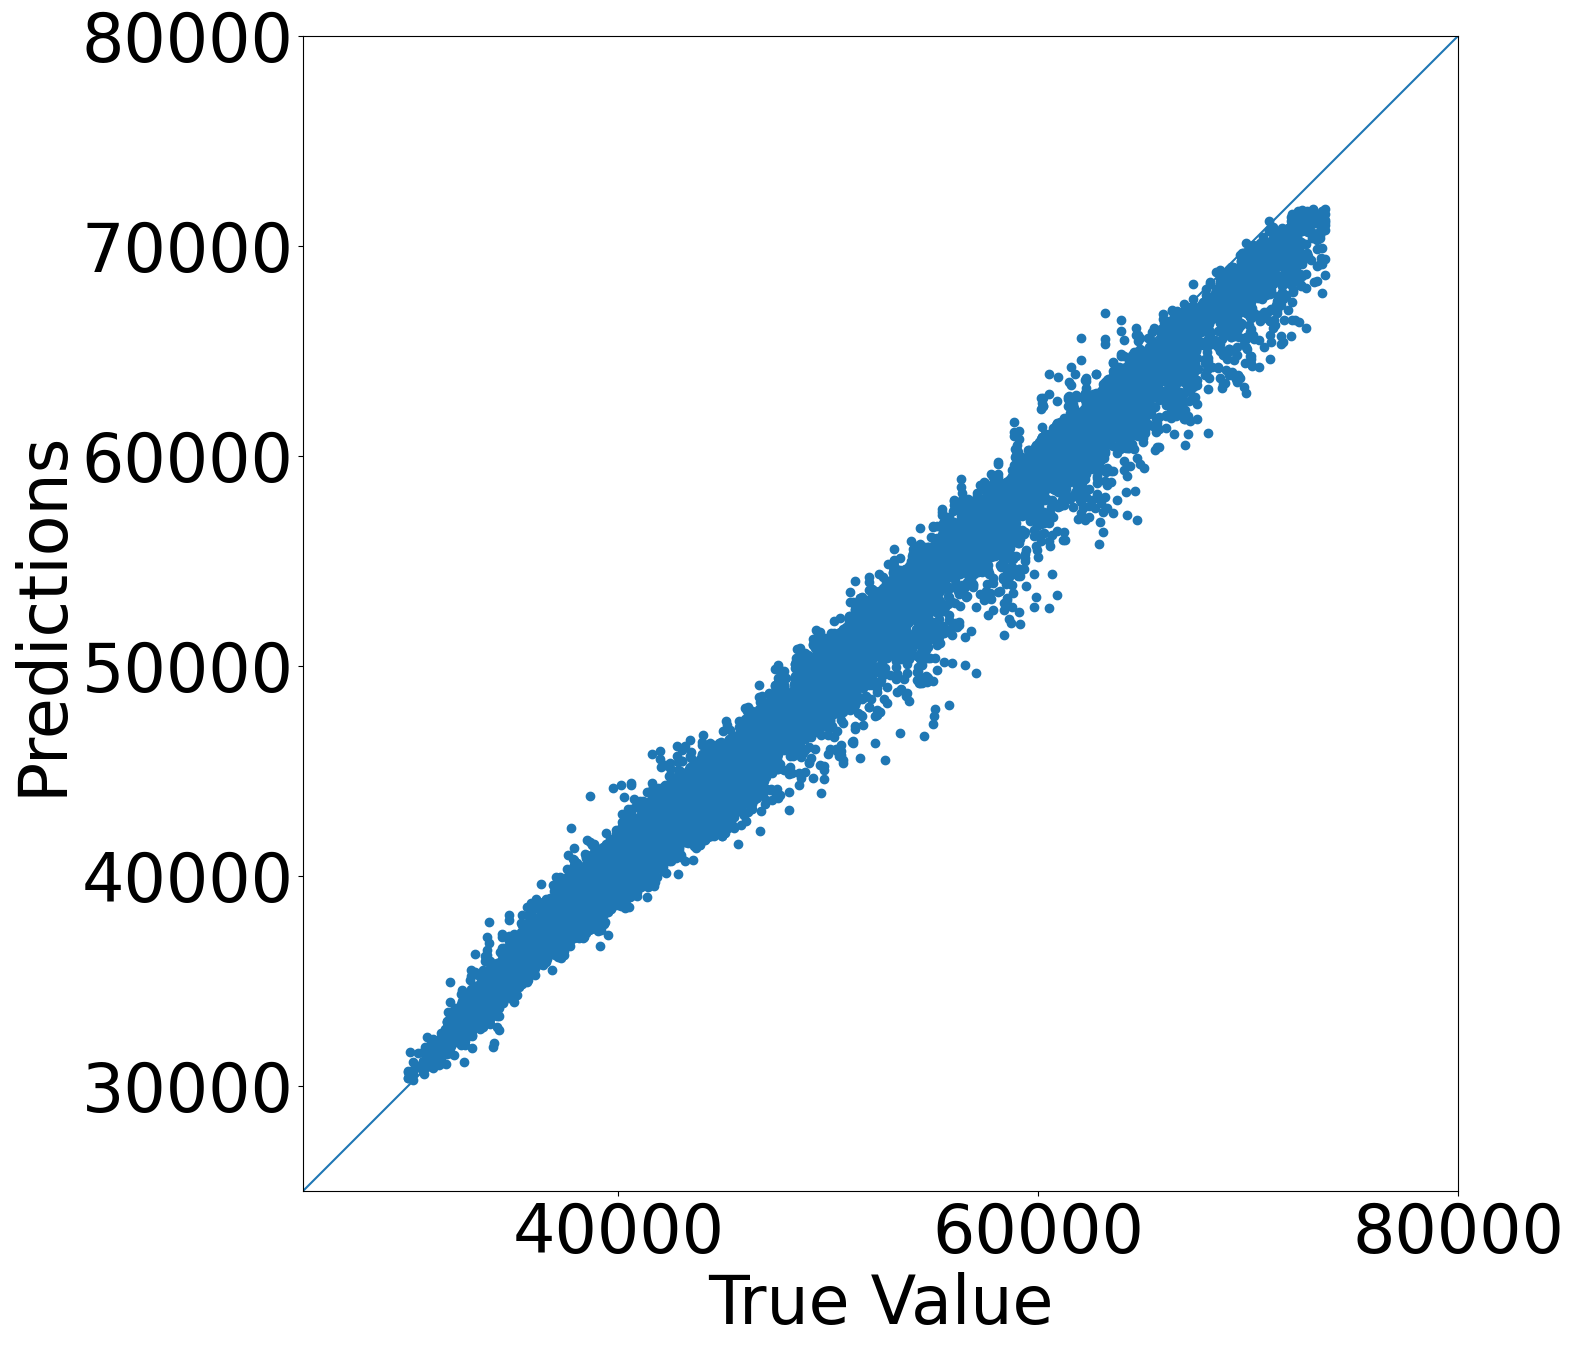

In [ ]:
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['actual'], predictions)
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [25000, 80000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
end = datetime.datetime.now()
print('total time:', end-start)

total time: 1:47:45.050818


In [ ]:
from keras.models import save_model
save_model(model,'Models/LSTM_model_1.0.h5',include_optimizer=True)
np.save('Models/LSTM_history_1.0.npy',history.history)